In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from prophet import Prophet
from xgboost import XGBRegressor

C:\Users\20200628\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
individual_houses = os.path.join(parent_dir, 'data', 'individual_houses.csv')
hourly_consumption = os.path.join(parent_dir, 'data', 'hourly_consumption_data.csv')


In [3]:
df_total_houses = pd.read_csv(individual_houses, index_col='Time')
df_total_houses.describe()

,House 1 Consumption,House 2 Consumption,House 3 Consumption,House 4 Consumption,House 5 Consumption,House 6 Consumption,House 7 Consumption,House 8 Consumption,House 9 Consumption,House 10 Consumption,House 11 Consumption,House 12 Consumption,House 13 Consumption,House 14 Consumption,House 15 Consumption
count,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000
mean,0.198818,0.197493,0.199519,0.198145,0.196687,0.199341,0.198647,0.197640,0.199320,0.198182,0.199382,0.199517,0.197314,0.198318,0.198727
std,0.272433,0.268788,0.272575,0.269327,0.265777,0.271560,0.271503,0.269316,0.270580,0.271353,0.273117,0.273231,0.269019,0.269444,0.273841
min,0.007698,0.009476,0.012133,0.011263,0.007086,0.007983,0.011430,0.012695,0.012555,0.013094,0.009931,0.011397,0.010195,0.007870,0.012082
25%,0.043280,0.043590,0.043910,0.044265,0.043797,0.044237,0.043943,0.043937,0.043791,0.044352,0.044142,0.044277,0.043922,0.044096,0.043664
50%,0.077105,0.077222,0.077378,0.076317,0.077199,0.076503,0.076876,0.078013,0.077501,0.076521,0.077170,0.076688,0.076561,0.077553,0.076599
75%,0.242870,0.243539,0.247508,0.244227,0.245432,0.249513,0.248111,0.246494,0.248040,0.243250,0.243324,0.246550,0.247240,0.240817,0.247352
max,2.511961,2.429432,2.294787,2.786303,2.469647,2.565852,2.373549,2.328693,2.337045,2.333137,2.503719,2.553943,3.020064,2.239978,2.740207


In [26]:
df_total_houses.head(3)

,House 1 Consumption,House 2 Consumption,House 3 Consumption,House 4 Consumption,House 5 Consumption,House 6 Consumption,House 7 Consumption,House 8 Consumption,House 9 Consumption,House 10 Consumption,House 11 Consumption,House 12 Consumption,House 13 Consumption,House 14 Consumption,House 15 Consumption
Time,,,,,,,,,,,,,,,
2017-10-21 00:00:00,0.021078,0.030934,0.036621,0.029738,0.025639,0.025998,0.032931,0.038195,0.030454,0.029653,0.026664,0.027893,0.020251,0.027781,0.033311
2017-10-21 01:00:00,0.053833,0.064004,0.051559,0.035536,0.061702,0.056889,0.087077,0.074045,0.048543,0.034148,0.043001,0.060187,0.041852,0.082297,0.073776
2017-10-21 02:00:00,0.025500,0.023700,0.029079,0.028968,0.026693,0.026208,0.032603,0.025896,0.023723,0.031513,0.024780,0.032704,0.026932,0.031303,0.017586


In [27]:
df_total_houses.index = pd.to_datetime(df_total_houses.index)
df_total_houses['Hour'] = df_total_houses.index.hour
df_total_houses['Day'] = df_total_houses.index.day
df_total_houses['Month'] = df_total_houses.index.month
df_total_houses['Quarter'] = df_total_houses.index.quarter
df_total_houses['Year'] = df_total_houses.index.year

df_total_houses.head(3)

,House 1 Consumption,House 2 Consumption,House 3 Consumption,House 4 Consumption,House 5 Consumption,House 6 Consumption,House 7 Consumption,House 8 Consumption,House 9 Consumption,House 10 Consumption,House 11 Consumption,House 12 Consumption,House 13 Consumption,House 14 Consumption,House 15 Consumption,Hour,Day,Month,Quarter,Year
Time,,,,,,,,,,,,,,,,,,,,
2017-10-21 00:00:00,0.021078,0.030934,0.036621,0.029738,0.025639,0.025998,0.032931,0.038195,0.030454,0.029653,0.026664,0.027893,0.020251,0.027781,0.033311,0,21,10,4,2017
2017-10-21 01:00:00,0.053833,0.064004,0.051559,0.035536,0.061702,0.056889,0.087077,0.074045,0.048543,0.034148,0.043001,0.060187,0.041852,0.082297,0.073776,1,21,10,4,2017
2017-10-21 02:00:00,0.025500,0.023700,0.029079,0.028968,0.026693,0.026208,0.032603,0.025896,0.023723,0.031513,0.024780,0.032704,0.026932,0.031303,0.017586,2,21,10,4,2017


In [4]:
def windowing(data, window_size, shuffle_buffer, batch_size):
    dataset = tf.expand_dims(data, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True) # window size = 24 + 1 (test)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # (train, test) 
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Main house

In [5]:
df_hourly_consumption = pd.read_csv(hourly_consumption, index_col='Time')
df_hourly_consumption.describe()

,Consumption
count,5589.000000
mean,0.198446
std,0.263227
min,0.024083
25%,0.047398
50%,0.076023
75%,0.249885
max,2.134392


In [6]:
df_hourly_consumption.index = pd.to_datetime(df_hourly_consumption.index)
# df_hourly_consumption['Hour'] = df_hourly_consumption.index.hour
# df_hourly_consumption['Day'] = df_hourly_consumption.index.day
# df_hourly_consumption['Month'] = df_hourly_consumption.index.month
# df_hourly_consumption['Quarter'] = df_hourly_consumption.index.quarter
# df_hourly_consumption['Year'] = df_hourly_consumption.index.year

df_hourly_consumption.head(3)

,Consumption
Time,
2017-10-21 00:00:00,0.027951
2017-10-21 01:00:00,0.056724
2017-10-21 02:00:00,0.028021


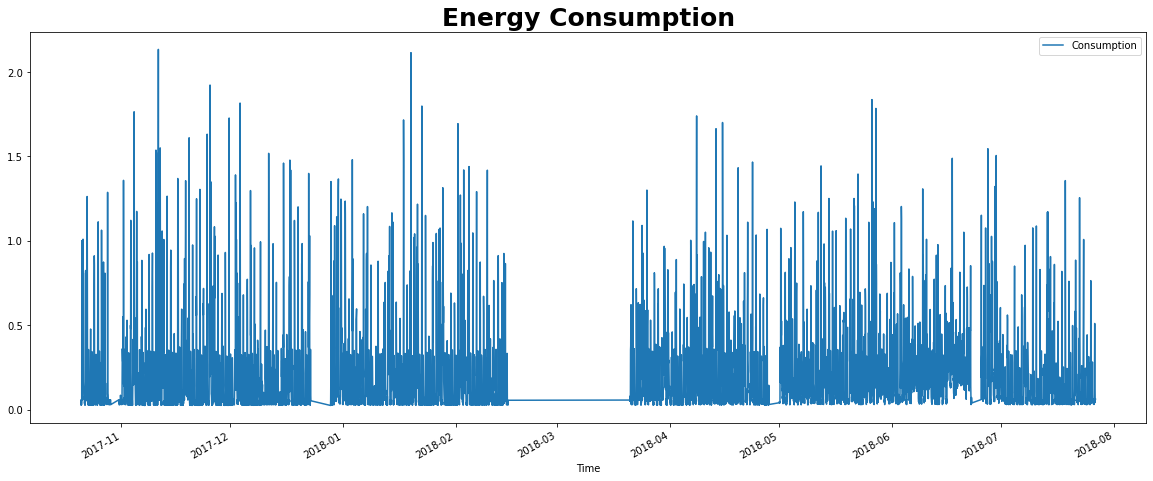

In [7]:
df_hourly_consumption.plot(figsize=(20,8))
plt.title('Energy Consumption', weight='bold', fontsize=25);

In [8]:
df_hourly_train = df_hourly_consumption[df_hourly_consumption.index < '2018-07-01']
df_hourly_test = df_hourly_consumption[df_hourly_consumption.index >= '2018-07-01']

print('Train:\t', len(df_hourly_train))
print('Test:\t', len(df_hourly_test))

Train:	 4965
Test:	 624


In [9]:
df_hourly_train

,Consumption
Time,
2017-10-21 00:00:00,0.027951
2017-10-21 01:00:00,0.056724
2017-10-21 02:00:00,0.028021
2017-10-21 03:00:00,0.057001
2017-10-21 04:00:00,0.027773
...,...
2018-06-30 19:00:00,0.594910
2018-06-30 20:00:00,0.604112
2018-06-30 21:00:00,0.132248


In [10]:
df_hourly_train = df_hourly_train.rename(columns={'Consumption': 'Consumption'}).reset_index()
df_hourly_test = df_hourly_test.rename(columns={'Consumption': 'Consumption'}).reset_index()

df_hourly_train = df_hourly_train.set_index('Time')['Consumption']
df_hourly_test = df_hourly_test.set_index('Time')['Consumption']

In [11]:
df_hourly_train

Time
2017-10-21 00:00:00    0.027951
2017-10-21 01:00:00    0.056724
2017-10-21 02:00:00    0.028021
2017-10-21 03:00:00    0.057001
2017-10-21 04:00:00    0.027773
                         ...   
2018-06-30 19:00:00    0.594910
2018-06-30 20:00:00    0.604112
2018-06-30 21:00:00    0.132248
2018-06-30 22:00:00    0.141922
2018-06-30 23:00:00    0.084293
Name: Consumption, Length: 4965, dtype: float64

In [12]:
df_hourly_train = df_hourly_train.to_frame('Consumption')
df_hourly_test = df_hourly_test.to_frame('Consumption')

In [13]:
df_hourly_train

,Consumption
Time,
2017-10-21 00:00:00,0.027951
2017-10-21 01:00:00,0.056724
2017-10-21 02:00:00,0.028021
2017-10-21 03:00:00,0.057001
2017-10-21 04:00:00,0.027773
...,...
2018-06-30 19:00:00,0.594910
2018-06-30 20:00:00,0.604112
2018-06-30 21:00:00,0.132248


In [15]:
dataset = tf.expand_dims(df_hourly_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02795149]]

 [[0.05672405]]

 [[0.0280215 ]]

 [[0.05700118]]]
y =  [[0.02777297]]

x =  [[[0.05672405]]

 [[0.0280215 ]]

 [[0.05700118]]

 [[0.02777297]]]
y =  [[0.05521627]]

x =  [[[0.0280215 ]]

 [[0.05700118]]

 [[0.02777297]]

 [[0.05521627]]]
y =  [[1.00063775]]

x =  [[[0.05700118]]

 [[0.02777297]]

 [[0.05521627]]

 [[1.00063775]]]
y =  [[0.39807097]]

x =  [[[0.02777297]]

 [[0.05521627]]

 [[1.00063775]]

 [[0.39807097]]]
y =  [[0.30847159]]

x =  [[[0.05521627]]

 [[1.00063775]]

 [[0.39807097]]

 [[0.30847159]]]
y =  [[0.07727468]]



In [16]:
train = windowing(df_hourly_train['Consumption'], 24, 72, 32)
test = windowing(df_hourly_test['Consumption'], 24, 72, 32)


In [18]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 16)            64        
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [19]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 7s 26ms/step - loss: 0.0676 - val_loss: 0.0413
Epoch 2/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0585 - val_loss: 0.0395
Epoch 3/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0563 - val_loss: 0.0401
Epoch 4/20
155/155 [==============================] - 3s 16ms/step - loss: 0.0553 - val_loss: 0.0400
Epoch 5/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0541 - val_loss: 0.0403
Epoch 6/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0535 - val_loss: 0.0377
Epoch 7/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0528 - val_loss: 0.0397
Epoch 8/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0524 - val_loss: 0.0399
Epoch 9/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0520 - val_loss: 0.0365
Epoch 10/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0519 - val_lo

In [20]:
window_size = 24
forecast = []

train_length = len(df_hourly_train)

forecast_series = df_hourly_consumption[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_hourly_test['Pred'] = results

1/1 [==============================] - 0s 25ms/step


In [21]:
df_hourly_test

,Consumption,Pred
Time,,
2018-07-01 00:00:00,0.064618,0.114554
2018-07-01 01:00:00,0.081771,0.082375
2018-07-01 02:00:00,0.059363,0.095399
2018-07-01 03:00:00,0.069960,0.084042
2018-07-01 04:00:00,0.081022,0.106334
...,...,...
2018-07-26 19:00:00,0.119373,0.385850
2018-07-26 20:00:00,0.048830,0.176910
2018-07-26 21:00:00,0.043194,0.119414


In [22]:
mse = round(mean_squared_error(df_hourly_test['Consumption'], df_hourly_test['Pred']), 3)
mse

0.034

In [23]:
df_hourly_test.to_csv('hourly_cons_pred.csv')

# House 2

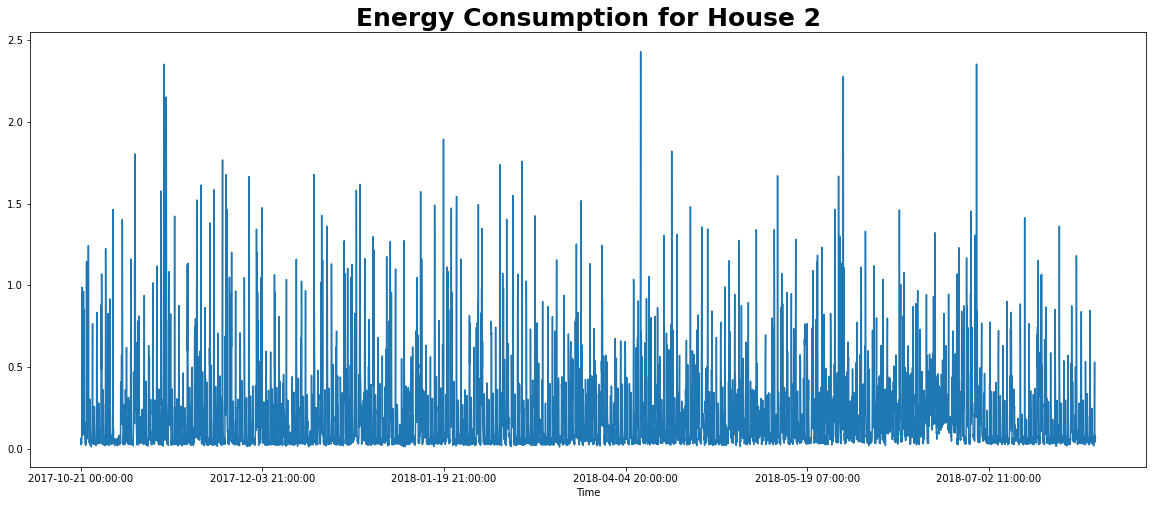

In [21]:
df_house2 = df_total_houses['House 2 Consumption']
df_house2.plot(figsize=(20,8))
plt.title('Energy Consumption for House 2', weight='bold', fontsize=25);

In [22]:
df_house2_train, df_house2_test = df_house2[df_house2.index < '2018-07-01'], df_house2[df_house2.index >= '2018-07-01']

print('Train:\t', len(df_house2_train))
print('Test:\t', len(df_house2_test))

Train:	 4965
Test:	 624


In [23]:
df_house2_train

Time
2017-10-21 00:00:00    0.030934
2017-10-21 01:00:00    0.064004
2017-10-21 02:00:00    0.023700
2017-10-21 03:00:00    0.039888
2017-10-21 04:00:00    0.035191
                         ...   
2018-06-30 19:00:00    0.529074
2018-06-30 20:00:00    0.767633
2018-06-30 21:00:00    0.155073
2018-06-30 22:00:00    0.089559
2018-06-30 23:00:00    0.078367
Name: House 2 Consumption, Length: 4965, dtype: float64

In [24]:
df_house2_train = df_house2_train.to_frame('House 2 Consumption')
df_house2_test = df_house2_test.to_frame('House 2 Consumption')

In [25]:
df_house2_train

,House 2 Consumption
Time,
2017-10-21 00:00:00,0.030934
2017-10-21 01:00:00,0.064004
2017-10-21 02:00:00,0.023700
2017-10-21 03:00:00,0.039888
2017-10-21 04:00:00,0.035191
...,...
2018-06-30 19:00:00,0.529074
2018-06-30 20:00:00,0.767633
2018-06-30 21:00:00,0.155073


In [26]:
dataset = tf.expand_dims(df_house2_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.0309338 ]]

 [[0.06400409]]

 [[0.02369952]]

 [[0.03988762]]]
y =  [[0.03519133]]

x =  [[[0.06400409]]

 [[0.02369952]]

 [[0.03988762]]

 [[0.03519133]]]
y =  [[0.05120482]]

x =  [[[0.02369952]]

 [[0.03988762]]

 [[0.03519133]]

 [[0.05120482]]]
y =  [[0.98767425]]

x =  [[[0.03988762]]

 [[0.03519133]]

 [[0.05120482]]

 [[0.98767425]]]
y =  [[0.33622713]]

x =  [[[0.03519133]]

 [[0.05120482]]

 [[0.98767425]]

 [[0.33622713]]]
y =  [[0.30971131]]

x =  [[[0.05120482]]

 [[0.98767425]]

 [[0.33622713]]

 [[0.30971131]]]
y =  [[0.09515399]]



In [27]:
train = windowing(df_house2_train['House 2 Consumption'], 24, 72, 32)
test = windowing(df_house2_test['House 2 Consumption'], 24, 72, 32)

In [28]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [29]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20


155/155 [==============================] - 6s 19ms/step - loss: 0.0714 - val_loss: 0.0396
Epoch 2/20
155/155 [==============================] - 3s 16ms/step - loss: 0.0615 - val_loss: 0.0394
Epoch 3/20
155/155 [==============================] - 2s 16ms/step - loss: 0.0602 - val_loss: 0.0375
Epoch 4/20
155/155 [==============================] - 3s 16ms/step - loss: 0.0592 - val_loss: 0.0381
Epoch 5/20
155/155 [==============================] - 3s 17ms/step - loss: 0.0586 - val_loss: 0.0368
Epoch 6/20
155/155 [==============================] - 3s 16ms/step - loss: 0.0578 - val_loss: 0.0390
Epoch 7/20
155/155 [==============================] - 3s 16ms/step - loss: 0.0575 - val_loss: 0.0385
Epoch 8/20
155/155 [==============================] - 2s 16ms/step - loss: 0.0572 - val_loss: 0.0386
Epoch 9/20
155/155 [==============================] - 3s 17ms/step - loss: 0.0568 - val_loss: 0.0361
Epoch 10/20
155/155 [==============================] - 3s 17ms/step - loss: 0.0565 - val_loss: 0.0370


In [30]:
window_size = 24
forecast = []

train_length = len(df_house2_train)

forecast_series = df_house2[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house2_test['Pred'] = results

1/1 [==============================] - 0s 25ms/step


In [31]:
df_house2_test

,House 2 Consumption,Pred
Time,,
2018-07-01 00:00:00,0.071015,0.109499
2018-07-01 01:00:00,0.070823,0.093376
2018-07-01 02:00:00,0.081333,0.097731
2018-07-01 03:00:00,0.079235,0.115006
2018-07-01 04:00:00,0.063697,0.120839
...,...,...
2018-07-26 19:00:00,0.119132,0.356746
2018-07-26 20:00:00,0.051317,0.163196
2018-07-26 21:00:00,0.041407,0.129200


In [32]:
df_house2_train

,House 2 Consumption
Time,
2017-10-21 00:00:00,0.030934
2017-10-21 01:00:00,0.064004
2017-10-21 02:00:00,0.023700
2017-10-21 03:00:00,0.039888
2017-10-21 04:00:00,0.035191
...,...
2018-06-30 19:00:00,0.529074
2018-06-30 20:00:00,0.767633
2018-06-30 21:00:00,0.155073


In [14]:
mse = round(mean_squared_error(df_house2_test['House 2 Consumption'], df_house2_test['Pred']), 3)
mse

0.034

In [15]:
df_house2_test.to_csv('house2_cons_pred.csv')

# House 3

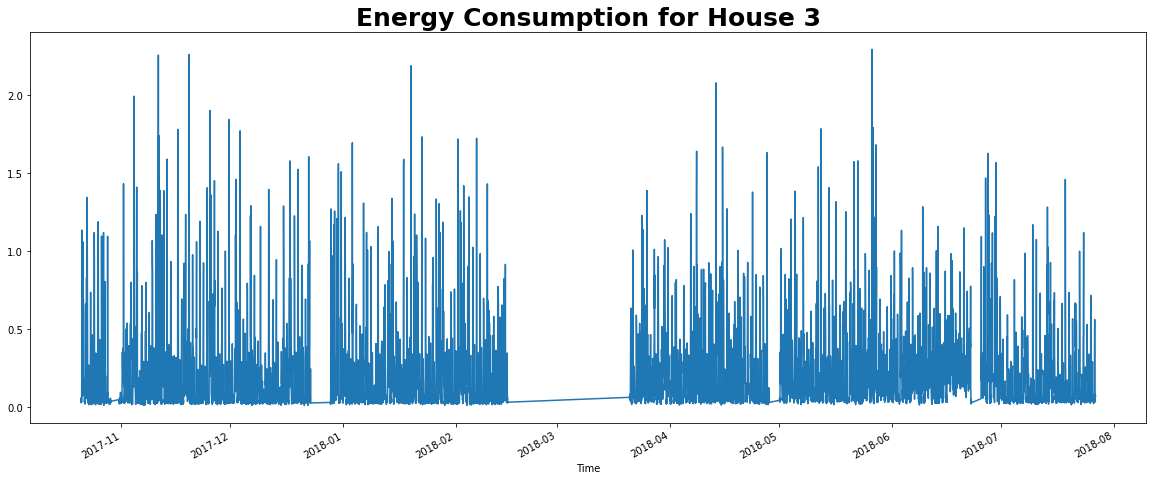

In [16]:
df_house3 = df_total_houses['House 3 Consumption']
df_house3.plot(figsize=(20,8))
plt.title('Energy Consumption for House 3', weight='bold', fontsize=25);

In [17]:
df_house3_train, df_house3_test = df_house3[df_house3.index < '2018-07-01'], df_house3[df_house3.index >= '2018-07-01']

print('Train:\t', len(df_house3_train))
print('Test:\t', len(df_house3_test))

Train:	 4965
Test:	 624


In [18]:
df_house3_train = df_house3_train.to_frame('House 3 Consumption')
df_house3_test = df_house3_test.to_frame('House 3 Consumption')

In [19]:
dataset = tf.expand_dims(df_house3_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.03662144]]

 [[0.05155941]]

 [[0.02907908]]

 [[0.06343222]]]
y =  [[0.03160763]]

x =  [[[0.05155941]]

 [[0.02907908]]

 [[0.06343222]]

 [[0.03160763]]]
y =  [[0.04582918]]

x =  [[[0.02907908]]

 [[0.06343222]]

 [[0.03160763]]

 [[0.04582918]]]
y =  [[1.13678351]]

x =  [[[0.06343222]]

 [[0.03160763]]

 [[0.04582918]]

 [[1.13678351]]]
y =  [[0.3429718]]

x =  [[[0.03160763]]

 [[0.04582918]]

 [[1.13678351]]

 [[0.3429718 ]]]
y =  [[0.35327542]]

x =  [[[0.04582918]]

 [[1.13678351]]

 [[0.3429718 ]]

 [[0.35327542]]]
y =  [[0.10214594]]



In [20]:
train = windowing(df_house3_train['House 3 Consumption'], 24, 72, 32)
test = windowing(df_house3_test['House 3 Consumption'], 24, 72, 32)

In [21]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [22]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 7s 22ms/step - loss: 0.0758 - val_loss: 0.0390
Epoch 2/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0649 - val_loss: 0.0398
Epoch 3/20
155/155 [==============================] - 3s 19ms/step - loss: 0.0616 - val_loss: 0.0398
Epoch 4/20
155/155 [==============================] - 3s 19ms/step - loss: 0.0600 - val_loss: 0.0409
Epoch 5/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0597 - val_loss: 0.0391
Epoch 6/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0585 - val_loss: 0.0388
Epoch 7/20
155/155 [==============================] - 2s 16ms/step - loss: 0.0584 - val_loss: 0.0383
Epoch 8/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0581 - val_loss: 0.0386
Epoch 9/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0580 - val_loss: 0.0358
Epoch 10/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0575 - val_lo

In [23]:
window_size = 24
forecast = []

train_length = len(df_house3_train)

forecast_series = df_house3[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house3_test['Pred'] = results

1/1 [==============================] - 0s 20ms/step


In [24]:
mse = round(mean_squared_error(df_house3_test['House 3 Consumption'], df_house3_test['Pred']), 3)
mse

0.035

In [25]:
df_house3_test.to_csv('house3_cons_pred.csv')

# House 4

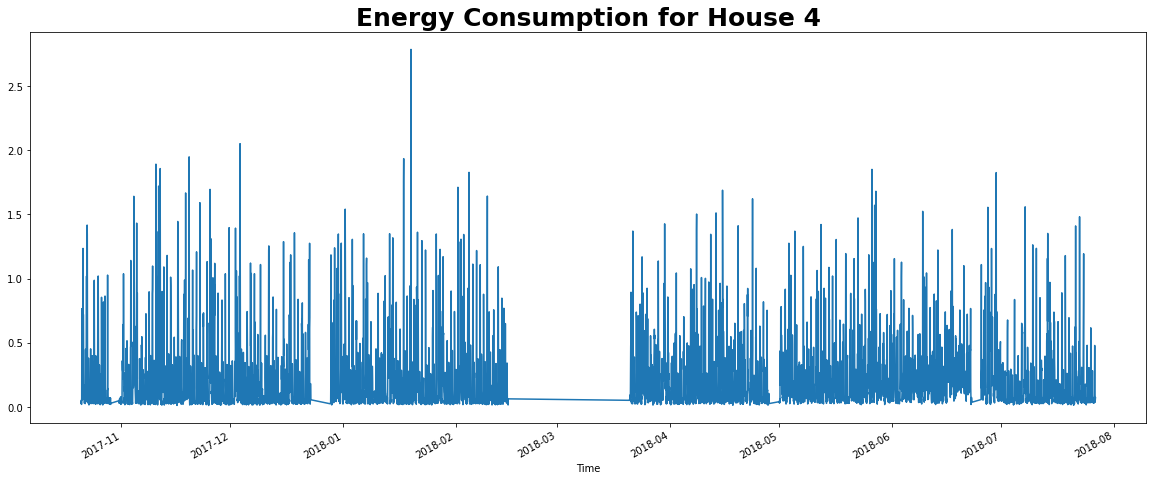

In [26]:
df_house4 = df_total_houses['House 4 Consumption']
df_house4.plot(figsize=(20,8))
plt.title('Energy Consumption for House 4', weight='bold', fontsize=25);

In [27]:
df_house4_train, df_house4_test = df_house4[df_house4.index < '2018-07-01'], df_house4[df_house4.index >= '2018-07-01']

print('Train:\t', len(df_house4_train))
print('Test:\t', len(df_house4_test))

Train:	 4965
Test:	 624


In [28]:
df_house4_train = df_house4_train.to_frame('House 4 Consumption')
df_house4_test = df_house4_test.to_frame('House 4 Consumption')

In [29]:
dataset = tf.expand_dims(df_house4_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02973777]]

 [[0.0355364 ]]

 [[0.02896823]]

 [[0.05265518]]]
y =  [[0.0194672]]

x =  [[[0.0355364 ]]

 [[0.02896823]]

 [[0.05265518]]

 [[0.0194672 ]]]
y =  [[0.07101064]]

x =  [[[0.02896823]]

 [[0.05265518]]

 [[0.0194672 ]]

 [[0.07101064]]]
y =  [[0.76529056]]

x =  [[[0.05265518]]

 [[0.0194672 ]]

 [[0.07101064]]

 [[0.76529056]]]
y =  [[0.29962199]]

x =  [[[0.0194672 ]]

 [[0.07101064]]

 [[0.76529056]]

 [[0.29962199]]]
y =  [[0.25494961]]

x =  [[[0.07101064]]

 [[0.76529056]]

 [[0.29962199]]

 [[0.25494961]]]
y =  [[0.06829086]]



In [30]:
train = windowing(df_house4_train['House 4 Consumption'], 24, 72, 32)
test = windowing(df_house4_test['House 4 Consumption'], 24, 72, 32)

In [31]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [32]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 14ms/step - loss: 0.0727 - val_loss: 0.0497
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0628 - val_loss: 0.0496
Epoch 3/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0600 - val_loss: 0.0479
Epoch 4/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0595 - val_loss: 0.0487
Epoch 5/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0592 - val_loss: 0.0475
Epoch 6/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0582 - val_loss: 0.0454
Epoch 7/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0579 - val_loss: 0.0458
Epoch 8/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0576 - val_loss: 0.0457
Epoch 9/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0570 - val_loss: 0.0416
Epoch 10/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0562 - val_lo

In [33]:
window_size = 24
forecast = []

train_length = len(df_house4_train)

forecast_series = df_house4[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house4_test['Pred'] = results

1/1 [==============================] - 0s 19ms/step


In [34]:
mse = round(mean_squared_error(df_house4_test['House 4 Consumption'], df_house4_test['Pred']), 3)
mse

0.042

In [35]:
df_house4_test.to_csv('house4_cons_pred.csv')

# House 5

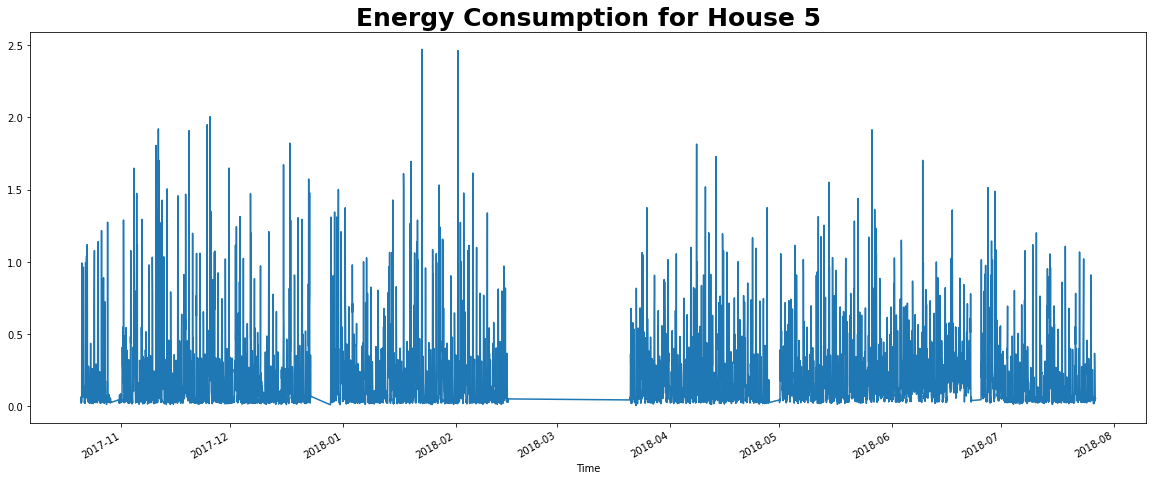

In [36]:
df_house5 = df_total_houses['House 5 Consumption']
df_house5.plot(figsize=(20,8))
plt.title('Energy Consumption for House 5', weight='bold', fontsize=25);

In [37]:
df_house5_train, df_house5_test = df_house5[df_house5.index < '2018-07-01'], df_house5[df_house5.index >= '2018-07-01']

print('Train:\t', len(df_house5_train))
print('Test:\t', len(df_house5_test))

Train:	 4965
Test:	 624


In [38]:
df_house5_train = df_house5_train.to_frame('House 5 Consumption')
df_house5_test = df_house5_test.to_frame('House 5 Consumption')

In [39]:
dataset = tf.expand_dims(df_house5_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02563872]]

 [[0.06170232]]

 [[0.02669251]]

 [[0.06811137]]]
y =  [[0.02758067]]

x =  [[[0.06170232]]

 [[0.02669251]]

 [[0.06811137]]

 [[0.02758067]]]
y =  [[0.04092206]]

x =  [[[0.02669251]]

 [[0.06811137]]

 [[0.02758067]]

 [[0.04092206]]]
y =  [[0.99256215]]

x =  [[[0.06811137]]

 [[0.02758067]]

 [[0.04092206]]

 [[0.99256215]]]
y =  [[0.35578571]]

x =  [[[0.02758067]]

 [[0.04092206]]

 [[0.99256215]]

 [[0.35578571]]]
y =  [[0.1803275]]

x =  [[[0.04092206]]

 [[0.99256215]]

 [[0.35578571]]

 [[0.1803275 ]]]
y =  [[0.09320619]]



In [40]:
train = windowing(df_house5_train['House 5 Consumption'], 24, 72, 32)
test = windowing(df_house5_test['House 5 Consumption'], 24, 72, 32)

In [41]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [42]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 15ms/step - loss: 0.0728 - val_loss: 0.0430
Epoch 2/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0630 - val_loss: 0.0379
Epoch 3/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0582 - val_loss: 0.0403
Epoch 4/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0575 - val_loss: 0.0381
Epoch 5/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0569 - val_loss: 0.0406
Epoch 6/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0564 - val_loss: 0.0368
Epoch 7/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0559 - val_loss: 0.0375
Epoch 8/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0554 - val_loss: 0.0397
Epoch 9/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0552 - val_loss: 0.0388
Epoch 10/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0550 - val_lo

In [43]:
window_size = 24
forecast = []

train_length = len(df_house5_train)

forecast_series = df_house5[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house5_test['Pred'] = results

1/1 [==============================] - 0s 20ms/step


In [44]:
mse = round(mean_squared_error(df_house5_test['House 5 Consumption'], df_house5_test['Pred']), 3)
mse

0.033

In [45]:
df_house5_test.to_csv('house5_cons_pred.csv')

# House 6

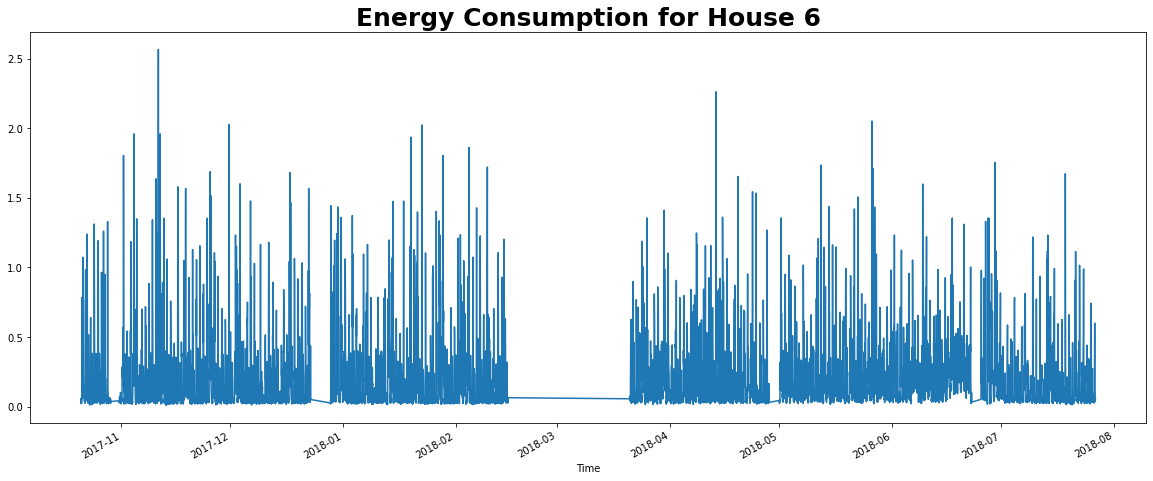

In [46]:
df_house6 = df_total_houses['House 6 Consumption']
df_house6.plot(figsize=(20,8))
plt.title('Energy Consumption for House 6', weight='bold', fontsize=25);

In [47]:
df_house6_train, df_house6_test = df_house6[df_house6.index < '2018-07-01'], df_house6[df_house6.index >= '2018-07-01']

print('Train:\t', len(df_house6_train))
print('Test:\t', len(df_house6_test))

Train:	 4965
Test:	 624


In [48]:
df_house6_train = df_house6_train.to_frame('House 6 Consumption')
df_house6_test = df_house6_test.to_frame('House 6 Consumption')

In [49]:
dataset = tf.expand_dims(df_house6_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02599753]]

 [[0.05688945]]

 [[0.02620842]]

 [[0.06014555]]]
y =  [[0.02177324]]

x =  [[[0.05688945]]

 [[0.02620842]]

 [[0.06014555]]

 [[0.02177324]]]
y =  [[0.05227302]]

x =  [[[0.02620842]]

 [[0.06014555]]

 [[0.02177324]]

 [[0.05227302]]]
y =  [[0.78215111]]

x =  [[[0.06014555]]

 [[0.02177324]]

 [[0.05227302]]

 [[0.78215111]]]
y =  [[0.45254312]]

x =  [[[0.02177324]]

 [[0.05227302]]

 [[0.78215111]]

 [[0.45254312]]]
y =  [[0.41976671]]

x =  [[[0.05227302]]

 [[0.78215111]]

 [[0.45254312]]

 [[0.41976671]]]
y =  [[0.07783455]]



In [50]:
train = windowing(df_house6_train['House 6 Consumption'], 24, 72, 32)
test = windowing(df_house6_test['House 6 Consumption'], 24, 72, 32)

In [51]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [52]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 14ms/step - loss: 0.0731 - val_loss: 0.0415
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0638 - val_loss: 0.0427
Epoch 3/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0609 - val_loss: 0.0396
Epoch 4/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0602 - val_loss: 0.0427
Epoch 5/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0594 - val_loss: 0.0425
Epoch 6/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0586 - val_loss: 0.0414
Epoch 7/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0580 - val_loss: 0.0387
Epoch 8/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0574 - val_loss: 0.0396
Epoch 9/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0569 - val_loss: 0.0385
Epoch 10/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0569 - val_lo

In [53]:
window_size = 24
forecast = []

train_length = len(df_house6_train)

forecast_series = df_house6[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house6_test['Pred'] = results

1/1 [==============================] - 0s 22ms/step


In [54]:
mse = round(mean_squared_error(df_house6_test['House 6 Consumption'], df_house6_test['Pred']), 3)
mse

0.038

In [55]:
df_house6_test.to_csv('house6_cons_pred.csv')

# House 7

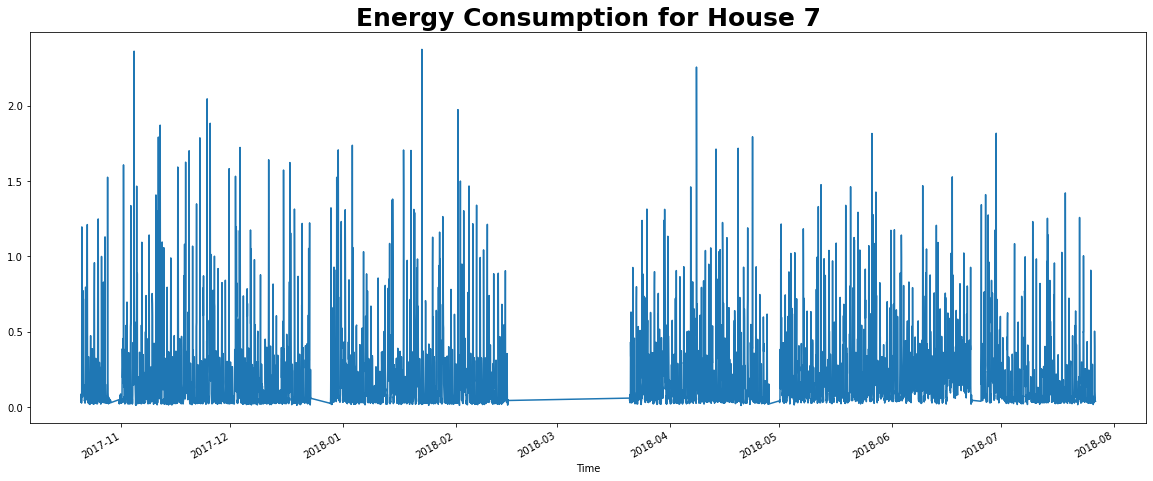

In [56]:
df_house7 = df_total_houses['House 7 Consumption']
df_house7.plot(figsize=(20,8))
plt.title('Energy Consumption for House 7', weight='bold', fontsize=25);

In [57]:
df_house7_train, df_house7_test = df_house7[df_house7.index < '2018-07-01'], df_house7[df_house7.index >= '2018-07-01']

print('Train:\t', len(df_house7_train))
print('Test:\t', len(df_house7_test))

Train:	 4965
Test:	 624


In [58]:
df_house7_train = df_house7_train.to_frame('House 7 Consumption')
df_house7_test = df_house7_test.to_frame('House 7 Consumption')

In [59]:
dataset = tf.expand_dims(df_house7_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.03293101]]

 [[0.08707692]]

 [[0.0326031 ]]

 [[0.06676186]]]
y =  [[0.027222]]

x =  [[[0.08707692]]

 [[0.0326031 ]]

 [[0.06676186]]

 [[0.027222  ]]]
y =  [[0.04145339]]

x =  [[[0.0326031 ]]

 [[0.06676186]]

 [[0.027222  ]]

 [[0.04145339]]]
y =  [[1.19581644]]

x =  [[[0.06676186]]

 [[0.027222  ]]

 [[0.04145339]]

 [[1.19581644]]]
y =  [[0.46385912]]

x =  [[[0.027222  ]]

 [[0.04145339]]

 [[1.19581644]]

 [[0.46385912]]]
y =  [[0.29250912]]

x =  [[[0.04145339]]

 [[1.19581644]]

 [[0.46385912]]

 [[0.29250912]]]
y =  [[0.07212166]]



In [60]:
train = windowing(df_house7_train['House 7 Consumption'], 24, 72, 32)
test = windowing(df_house7_test['House 7 Consumption'], 24, 72, 32)

In [61]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [62]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 15ms/step - loss: 0.0695 - val_loss: 0.0428
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0614 - val_loss: 0.0402
Epoch 3/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0600 - val_loss: 0.0409
Epoch 4/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0593 - val_loss: 0.0401
Epoch 5/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0584 - val_loss: 0.0405
Epoch 6/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0581 - val_loss: 0.0396
Epoch 7/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0579 - val_loss: 0.0433
Epoch 8/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0575 - val_loss: 0.0408
Epoch 9/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0575 - val_loss: 0.0393
Epoch 10/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0571 - val_lo

In [63]:
window_size = 24
forecast = []

train_length = len(df_house7_train)

forecast_series = df_house7[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house7_test['Pred'] = results

1/1 [==============================] - 0s 20ms/step


In [64]:
mse = round(mean_squared_error(df_house7_test['House 7 Consumption'], df_house7_test['Pred']), 3)
mse

0.039

In [65]:
df_house7_test.to_csv('house7_cons_pred.csv')

# House 8

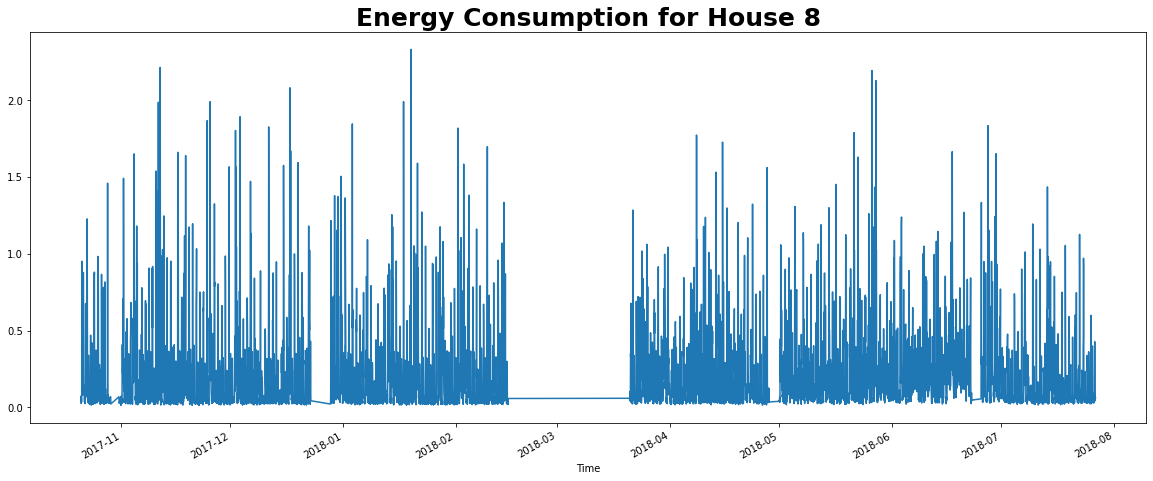

In [66]:
df_house8 = df_total_houses['House 8 Consumption']
df_house8.plot(figsize=(20,8))
plt.title('Energy Consumption for House 8', weight='bold', fontsize=25);

In [67]:
df_house8_train, df_house8_test = df_house8[df_house8.index < '2018-07-01'], df_house8[df_house8.index >= '2018-07-01']

print('Train:\t', len(df_house8_train))
print('Test:\t', len(df_house8_test))

Train:	 4965
Test:	 624


In [68]:
df_house8_train = df_house8_train.to_frame('House 8 Consumption')
df_house8_test = df_house8_test.to_frame('House 8 Consumption')

In [69]:
dataset = tf.expand_dims(df_house8_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.03819475]]

 [[0.07404462]]

 [[0.02589591]]

 [[0.05856711]]]
y =  [[0.03441671]]

x =  [[[0.07404462]]

 [[0.02589591]]

 [[0.05856711]]

 [[0.03441671]]]
y =  [[0.0696107]]

x =  [[[0.02589591]]

 [[0.05856711]]

 [[0.03441671]]

 [[0.0696107 ]]]
y =  [[0.95063884]]

x =  [[[0.05856711]]

 [[0.03441671]]

 [[0.0696107 ]]

 [[0.95063884]]]
y =  [[0.38268891]]

x =  [[[0.03441671]]

 [[0.0696107 ]]

 [[0.95063884]]

 [[0.38268891]]]
y =  [[0.16065802]]

x =  [[[0.0696107 ]]

 [[0.95063884]]

 [[0.38268891]]

 [[0.16065802]]]
y =  [[0.10003455]]



In [70]:
train = windowing(df_house8_train['House 8 Consumption'], 24, 72, 32)
test = windowing(df_house8_test['House 8 Consumption'], 24, 72, 32)

In [71]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_6 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [72]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 15ms/step - loss: 0.0743 - val_loss: 0.0458
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0637 - val_loss: 0.0400
Epoch 3/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0612 - val_loss: 0.0433
Epoch 4/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0609 - val_loss: 0.0381
Epoch 5/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0598 - val_loss: 0.0384
Epoch 6/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0593 - val_loss: 0.0393
Epoch 7/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0591 - val_loss: 0.0398
Epoch 8/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0586 - val_loss: 0.0380
Epoch 9/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0581 - val_loss: 0.0371
Epoch 10/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0578 - val_lo

In [73]:
window_size = 24
forecast = []

train_length = len(df_house8_train)

forecast_series = df_house8[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house8_test['Pred'] = results

1/1 [==============================] - 0s 20ms/step


In [74]:
mse = round(mean_squared_error(df_house8_test['House 8 Consumption'], df_house8_test['Pred']), 3)
mse

0.033

In [75]:
df_house8_test.to_csv('house8_cons_pred.csv')

# House 9

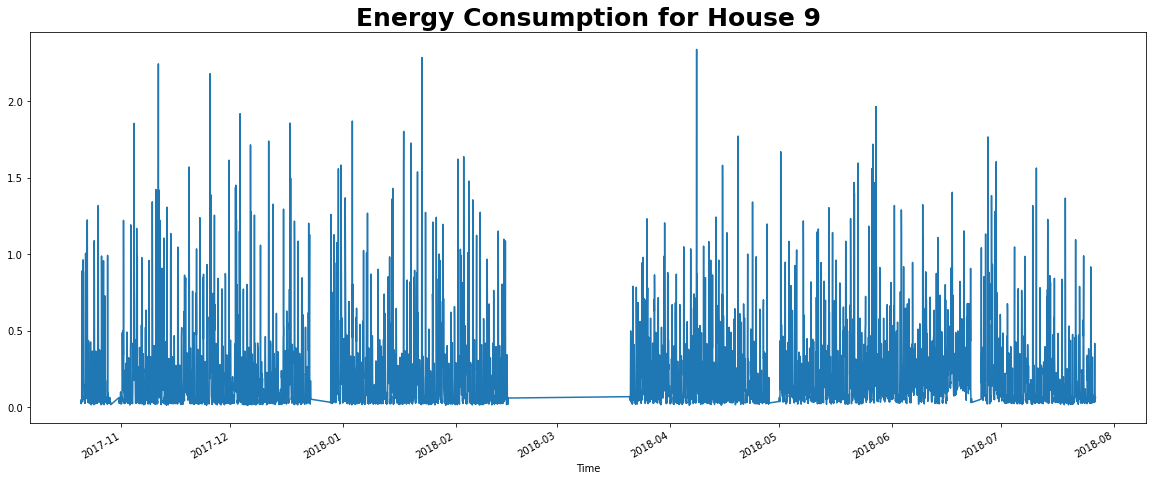

In [76]:
df_house9 = df_total_houses['House 9 Consumption']
df_house9.plot(figsize=(20,8))
plt.title('Energy Consumption for House 9', weight='bold', fontsize=25);

In [77]:
df_house9_train, df_house9_test = df_house9[df_house9.index < '2018-07-01'], df_house9[df_house9.index >= '2018-07-01']

print('Train:\t', len(df_house9_train))
print('Test:\t', len(df_house9_test))

Train:	 4965
Test:	 624


In [78]:
df_house9_train = df_house9_train.to_frame('House 9 Consumption')
df_house9_test = df_house9_test.to_frame('House 9 Consumption')

In [79]:
dataset = tf.expand_dims(df_house9_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.03045367]]

 [[0.04854251]]

 [[0.02372311]]

 [[0.0486766 ]]]
y =  [[0.02905962]]

x =  [[[0.04854251]]

 [[0.02372311]]

 [[0.0486766 ]]

 [[0.02905962]]]
y =  [[0.04563181]]

x =  [[[0.02372311]]

 [[0.0486766 ]]

 [[0.02905962]]

 [[0.04563181]]]
y =  [[0.8906513]]

x =  [[[0.0486766 ]]

 [[0.02905962]]

 [[0.04563181]]

 [[0.8906513 ]]]
y =  [[0.3873724]]

x =  [[[0.02905962]]

 [[0.04563181]]

 [[0.8906513 ]]

 [[0.3873724 ]]]
y =  [[0.24634313]]

x =  [[[0.04563181]]

 [[0.8906513 ]]

 [[0.3873724 ]]

 [[0.24634313]]]
y =  [[0.04331475]]



In [80]:
train = windowing(df_house9_train['House 9 Consumption'], 24, 72, 32)
test = windowing(df_house9_test['House 9 Consumption'], 24, 72, 32)

In [81]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [82]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 14ms/step - loss: 0.0728 - val_loss: 0.0456
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0632 - val_loss: 0.0435
Epoch 3/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0608 - val_loss: 0.0424
Epoch 4/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0600 - val_loss: 0.0405
Epoch 5/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0592 - val_loss: 0.0425
Epoch 6/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0587 - val_loss: 0.0416
Epoch 7/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0586 - val_loss: 0.0378
Epoch 8/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0578 - val_loss: 0.0407
Epoch 9/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0575 - val_loss: 0.0387
Epoch 10/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0571 - val_lo

In [83]:
window_size = 24
forecast = []

train_length = len(df_house9_train)

forecast_series = df_house9[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house9_test['Pred'] = results

1/1 [==============================] - 0s 21ms/step


In [84]:
mse = round(mean_squared_error(df_house9_test['House 9 Consumption'], df_house9_test['Pred']), 3)
mse

0.036

In [85]:
df_house9_test.to_csv('house9_cons_pred.csv')

# House 10

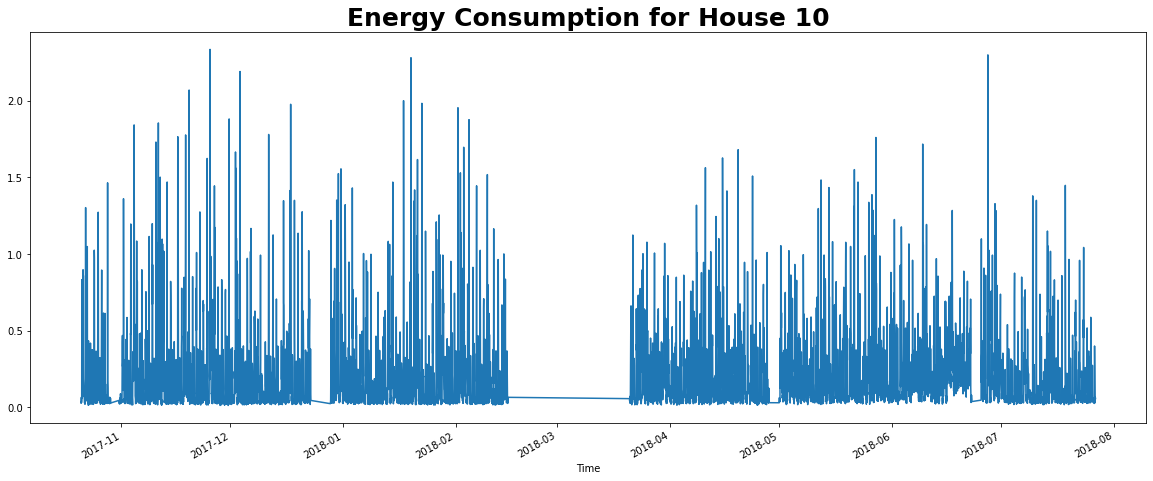

In [86]:
df_house10 = df_total_houses['House 10 Consumption']
df_house10.plot(figsize=(20,8))
plt.title('Energy Consumption for House 10', weight='bold', fontsize=25);

In [87]:
df_house10_train, df_house10_test = df_house10[df_house10.index < '2018-07-01'], df_house10[df_house10.index >= '2018-07-01']

print('Train:\t', len(df_house10_train))
print('Test:\t', len(df_house10_test))

Train:	 4965
Test:	 624


In [88]:
df_house10_train = df_house10_train.to_frame('House 10 Consumption')
df_house10_test = df_house10_test.to_frame('House 10 Consumption')

In [89]:
dataset = tf.expand_dims(df_house10_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02965307]]

 [[0.03414796]]

 [[0.03151284]]

 [[0.0660935 ]]]
y =  [[0.03175082]]

x =  [[[0.03414796]]

 [[0.03151284]]

 [[0.0660935 ]]

 [[0.03175082]]]
y =  [[0.04923695]]

x =  [[[0.03151284]]

 [[0.0660935 ]]

 [[0.03175082]]

 [[0.04923695]]]
y =  [[0.8325368]]

x =  [[[0.0660935 ]]

 [[0.03175082]]

 [[0.04923695]]

 [[0.8325368 ]]]
y =  [[0.34692874]]

x =  [[[0.03175082]]

 [[0.04923695]]

 [[0.8325368 ]]

 [[0.34692874]]]
y =  [[0.35044744]]

x =  [[[0.04923695]]

 [[0.8325368 ]]

 [[0.34692874]]

 [[0.35044744]]]
y =  [[0.06273821]]



In [90]:
train = windowing(df_house10_train['House 10 Consumption'], 24, 72, 32)
test = windowing(df_house10_test['House 10 Consumption'], 24, 72, 32)

In [91]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_8 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 16)                528       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [92]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 14ms/step - loss: 0.0745 - val_loss: 0.0419
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0650 - val_loss: 0.0410
Epoch 3/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0616 - val_loss: 0.0402
Epoch 4/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0607 - val_loss: 0.0385
Epoch 5/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0601 - val_loss: 0.0382
Epoch 6/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0596 - val_loss: 0.0375
Epoch 7/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0586 - val_loss: 0.0366
Epoch 8/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0581 - val_loss: 0.0383
Epoch 9/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0580 - val_loss: 0.0360
Epoch 10/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0575 - val_lo

In [93]:
window_size = 24
forecast = []

train_length = len(df_house10_train)

forecast_series = df_house10[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house10_test['Pred'] = results

1/1 [==============================] - 0s 20ms/step


In [94]:
mse = round(mean_squared_error(df_house10_test['House 10 Consumption'], df_house10_test['Pred']), 3)
mse

0.034

In [95]:
df_house10_test.to_csv('house10_cons_pred.csv')

# House 11

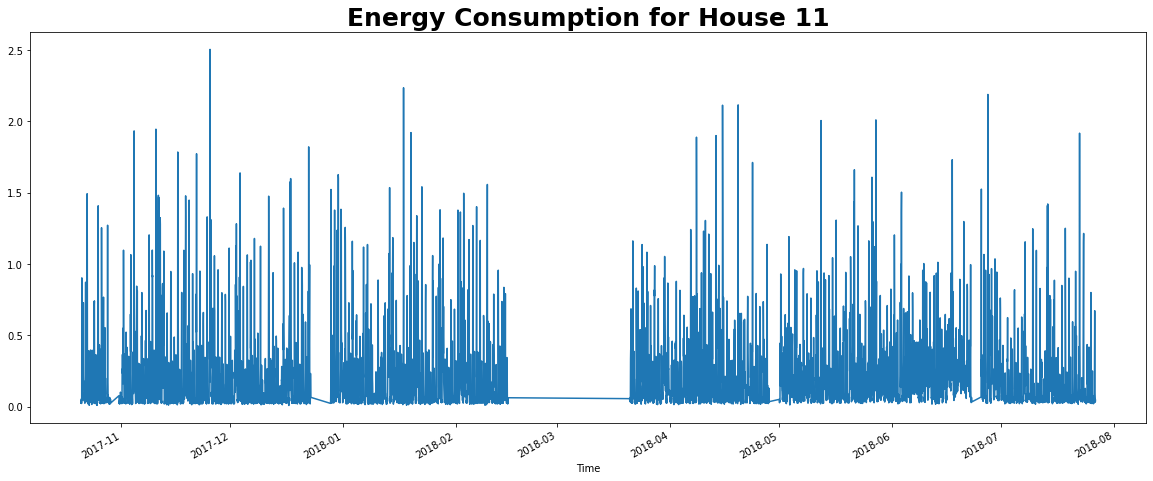

In [96]:
df_house11 = df_total_houses['House 11 Consumption']
df_house11.plot(figsize=(20,8))
plt.title('Energy Consumption for House 11', weight='bold', fontsize=25);

In [97]:
df_house11_train, df_house11_test = df_house11[df_house11.index < '2018-07-01'], df_house11[df_house11.index >= '2018-07-01']

print('Train:\t', len(df_house11_train))
print('Test:\t', len(df_house11_test))

Train:	 4965
Test:	 624


In [98]:
df_house11_train = df_house11_train.to_frame('House 11 Consumption')
df_house11_test = df_house11_test.to_frame('House 11 Consumption')

In [99]:
dataset = tf.expand_dims(df_house11_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02666426]]

 [[0.04300059]]

 [[0.02477988]]

 [[0.05592668]]]
y =  [[0.02381456]]

x =  [[[0.04300059]]

 [[0.02477988]]

 [[0.05592668]]

 [[0.02381456]]]
y =  [[0.03154896]]

x =  [[[0.02477988]]

 [[0.05592668]]

 [[0.02381456]]

 [[0.03154896]]]
y =  [[0.90343105]]

x =  [[[0.05592668]]

 [[0.02381456]]

 [[0.03154896]]

 [[0.90343105]]]
y =  [[0.39310479]]

x =  [[[0.02381456]]

 [[0.03154896]]

 [[0.90343105]]

 [[0.39310479]]]
y =  [[0.36305341]]

x =  [[[0.03154896]]

 [[0.90343105]]

 [[0.39310479]]

 [[0.36305341]]]
y =  [[0.0650462]]



In [100]:
train = windowing(df_house11_train['House 11 Consumption'], 24, 72, 32)
test = windowing(df_house11_test['House 11 Consumption'], 24, 72, 32)

In [101]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 24, 16)            64        
                                                                 
 bidirectional_9 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [102]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 15ms/step - loss: 0.0775 - val_loss: 0.0531
Epoch 2/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0671 - val_loss: 0.0516
Epoch 3/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0627 - val_loss: 0.0494
Epoch 4/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0600 - val_loss: 0.0516
Epoch 5/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0585 - val_loss: 0.0482
Epoch 6/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0580 - val_loss: 0.0475
Epoch 7/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0578 - val_loss: 0.0473
Epoch 8/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0577 - val_loss: 0.0470
Epoch 9/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0574 - val_loss: 0.0469
Epoch 10/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0572 - val_lo

In [103]:
window_size = 24
forecast = []

train_length = len(df_house11_train)

forecast_series = df_house11[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house11_test['Pred'] = results

1/1 [==============================] - 0s 21ms/step


In [104]:
mse = round(mean_squared_error(df_house11_test['House 11 Consumption'], df_house11_test['Pred']), 3)
mse

0.043

In [105]:
df_house11_test.to_csv('house11_cons_pred.csv')

# House 12

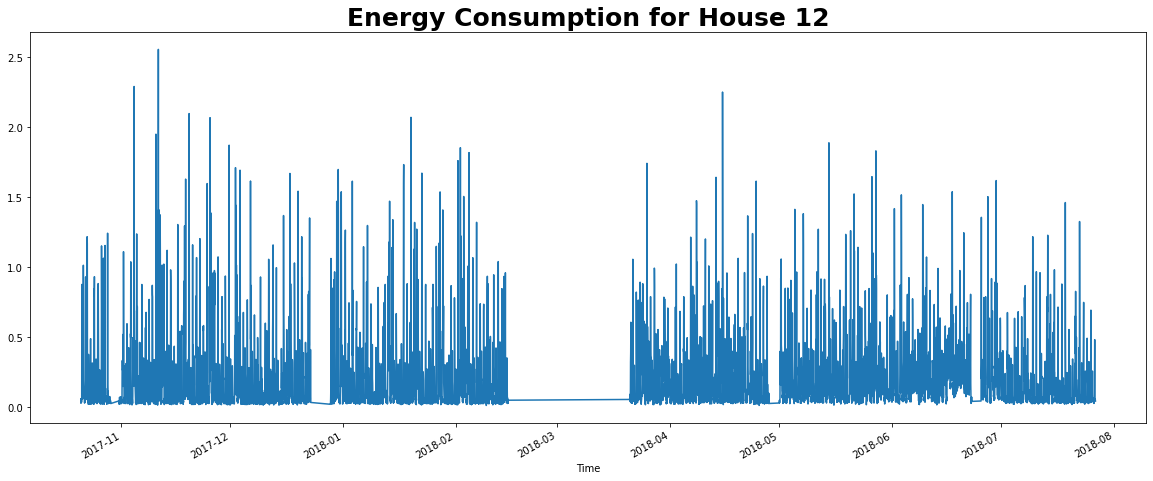

In [106]:
df_house12 = df_total_houses['House 12 Consumption']
df_house12.plot(figsize=(20,8))
plt.title('Energy Consumption for House 12', weight='bold', fontsize=25);

In [107]:
df_house12_train, df_house12_test = df_house12[df_house12.index < '2018-07-01'], df_house12[df_house12.index >= '2018-07-01']

print('Train:\t', len(df_house12_train))
print('Test:\t', len(df_house12_test))

Train:	 4965
Test:	 624


In [108]:
df_house12_train = df_house12_train.to_frame('House 12 Consumption')
df_house12_test = df_house12_test.to_frame('House 12 Consumption')

In [109]:
dataset = tf.expand_dims(df_house12_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02789291]]

 [[0.06018682]]

 [[0.03270413]]

 [[0.05888326]]]
y =  [[0.03437519]]

x =  [[[0.06018682]]

 [[0.03270413]]

 [[0.05888326]]

 [[0.03437519]]]
y =  [[0.05803647]]

x =  [[[0.03270413]]

 [[0.05888326]]

 [[0.03437519]]

 [[0.05803647]]]
y =  [[0.87539775]]

x =  [[[0.05888326]]

 [[0.03437519]]

 [[0.05803647]]

 [[0.87539775]]]
y =  [[0.23323676]]

x =  [[[0.03437519]]

 [[0.05803647]]

 [[0.87539775]]

 [[0.23323676]]]
y =  [[0.37557054]]

x =  [[[0.05803647]]

 [[0.87539775]]

 [[0.23323676]]

 [[0.37557054]]]
y =  [[0.09422743]]



In [110]:
train = windowing(df_house12_train['House 12 Consumption'], 24, 72, 32)
test = windowing(df_house12_test['House 12 Consumption'], 24, 72, 32)

In [111]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 24, 16)            64        
                                                                 
 bidirectional_10 (Bidirecti  (None, 32)               4224      
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [112]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 14ms/step - loss: 0.0728 - val_loss: 0.0391
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0632 - val_loss: 0.0378
Epoch 3/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0615 - val_loss: 0.0363
Epoch 4/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0606 - val_loss: 0.0348
Epoch 5/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0601 - val_loss: 0.0373
Epoch 6/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0599 - val_loss: 0.0330
Epoch 7/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0590 - val_loss: 0.0361
Epoch 8/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0589 - val_loss: 0.0341
Epoch 9/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0589 - val_loss: 0.0346
Epoch 10/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0583 - val_lo

In [113]:
window_size = 24
forecast = []

train_length = len(df_house12_train)

forecast_series = df_house12[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house12_test['Pred'] = results

1/1 [==============================] - 0s 20ms/step


In [114]:
mse = round(mean_squared_error(df_house12_test['House 12 Consumption'], df_house12_test['Pred']), 3)
mse

0.033

In [115]:
df_house12_test.to_csv('house12_cons_pred.csv')

# House 13

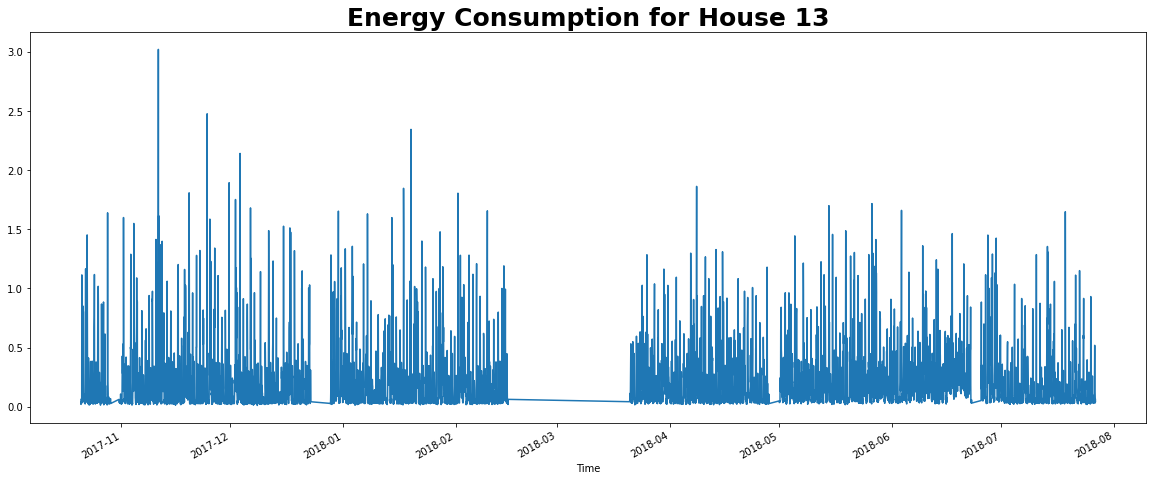

In [116]:
df_house13 = df_total_houses['House 13 Consumption']
df_house13.plot(figsize=(20,8))
plt.title('Energy Consumption for House 13', weight='bold', fontsize=25);

In [117]:
df_house13_train, df_house13_test = df_house13[df_house13.index < '2018-07-01'], df_house13[df_house13.index >= '2018-07-01']

print('Train:\t', len(df_house13_train))
print('Test:\t', len(df_house13_test))

Train:	 4965
Test:	 624


In [118]:
df_house13_train = df_house13_train.to_frame('House 13 Consumption')
df_house13_test = df_house13_test.to_frame('House 13 Consumption')

In [119]:
dataset = tf.expand_dims(df_house13_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02025134]]

 [[0.04185223]]

 [[0.0269317 ]]

 [[0.06599869]]]
y =  [[0.02735697]]

x =  [[[0.04185223]]

 [[0.0269317 ]]

 [[0.06599869]]

 [[0.02735697]]]
y =  [[0.04088612]]

x =  [[[0.0269317 ]]

 [[0.06599869]]

 [[0.02735697]]

 [[0.04088612]]]
y =  [[1.1137461]]

x =  [[[0.06599869]]

 [[0.02735697]]

 [[0.04088612]]

 [[1.1137461 ]]]
y =  [[0.33589046]]

x =  [[[0.02735697]]

 [[0.04088612]]

 [[1.1137461 ]]

 [[0.33589046]]]
y =  [[0.35165621]]

x =  [[[0.04088612]]

 [[1.1137461 ]]

 [[0.33589046]]

 [[0.35165621]]]
y =  [[0.09762672]]



In [120]:
train = windowing(df_house13_train['House 13 Consumption'], 24, 72, 32)
test = windowing(df_house13_test['House 13 Consumption'], 24, 72, 32)

In [121]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 24, 16)            64        
                                                                 
 bidirectional_11 (Bidirecti  (None, 32)               4224      
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dense_23 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [122]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 15ms/step - loss: 0.0694 - val_loss: 0.0419
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0616 - val_loss: 0.0401
Epoch 3/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0592 - val_loss: 0.0393
Epoch 4/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0582 - val_loss: 0.0407
Epoch 5/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0577 - val_loss: 0.0420
Epoch 6/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0572 - val_loss: 0.0388
Epoch 7/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0563 - val_loss: 0.0398
Epoch 8/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0563 - val_loss: 0.0397
Epoch 9/20
155/155 [==============================] - 2s 12ms/step - loss: 0.0561 - val_loss: 0.0394
Epoch 10/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0560 - val_lo

In [123]:
window_size = 24
forecast = []

train_length = len(df_house13_train)

forecast_series = df_house13[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house13_test['Pred'] = results

1/1 [==============================] - 0s 20ms/step


In [124]:
mse = round(mean_squared_error(df_house13_test['House 13 Consumption'], df_house13_test['Pred']), 3)
mse

0.037

In [125]:
df_house13_test.to_csv('house13_cons_pred.csv')

# House 14

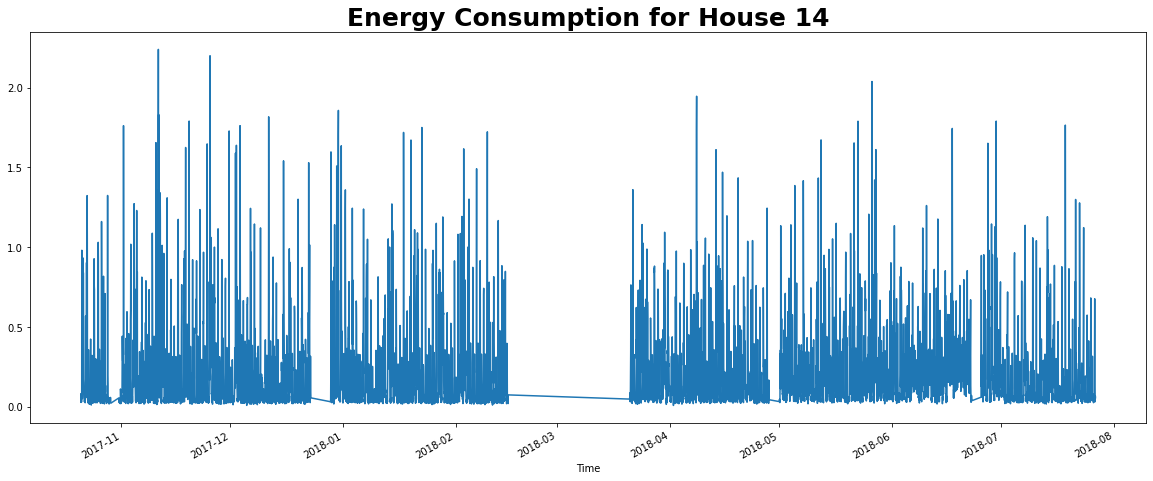

In [126]:
df_house14 = df_total_houses['House 14 Consumption']
df_house14.plot(figsize=(20,8))
plt.title('Energy Consumption for House 14', weight='bold', fontsize=25);

In [127]:
df_house14_train, df_house14_test = df_house14[df_house14.index < '2018-07-01'], df_house14[df_house14.index >= '2018-07-01']

print('Train:\t', len(df_house14_train))
print('Test:\t', len(df_house14_test))

Train:	 4965
Test:	 624


In [128]:
df_house14_train = df_house14_train.to_frame('House 14 Consumption')
df_house14_test = df_house14_test.to_frame('House 14 Consumption')

In [129]:
dataset = tf.expand_dims(df_house14_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.02778143]]

 [[0.08229702]]

 [[0.03130324]]

 [[0.06007045]]]
y =  [[0.02908115]]

x =  [[[0.08229702]]

 [[0.03130324]]

 [[0.06007045]]

 [[0.02908115]]]
y =  [[0.06771333]]

x =  [[[0.03130324]]

 [[0.06007045]]

 [[0.02908115]]

 [[0.06771333]]]
y =  [[0.98074365]]

x =  [[[0.06007045]]

 [[0.02908115]]

 [[0.06771333]]

 [[0.98074365]]]
y =  [[0.30514101]]

x =  [[[0.02908115]]

 [[0.06771333]]

 [[0.98074365]]

 [[0.30514101]]]
y =  [[0.30449765]]

x =  [[[0.06771333]]

 [[0.98074365]]

 [[0.30514101]]

 [[0.30449765]]]
y =  [[0.08371063]]



In [130]:
train = windowing(df_house14_train['House 14 Consumption'], 24, 72, 32)
test = windowing(df_house14_test['House 14 Consumption'], 24, 72, 32)

In [131]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 24, 16)            64        
                                                                 
 bidirectional_12 (Bidirecti  (None, 32)               4224      
 onal)                                                           
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [132]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 15ms/step - loss: 0.0731 - val_loss: 0.0495
Epoch 2/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0600 - val_loss: 0.0472
Epoch 3/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0581 - val_loss: 0.0439
Epoch 4/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0571 - val_loss: 0.0418
Epoch 5/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0566 - val_loss: 0.0443
Epoch 6/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0565 - val_loss: 0.0452
Epoch 7/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0561 - val_loss: 0.0437
Epoch 8/20
155/155 [==============================] - 2s 15ms/step - loss: 0.0557 - val_loss: 0.0414
Epoch 9/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0555 - val_loss: 0.0417
Epoch 10/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0554 - val_lo

In [133]:
window_size = 24
forecast = []

train_length = len(df_house14_train)

forecast_series = df_house14[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house14_test['Pred'] = results

1/1 [==============================] - 0s 21ms/step


In [134]:
mse = round(mean_squared_error(df_house14_test['House 14 Consumption'], df_house14_test['Pred']), 3)
mse

0.038

In [135]:
df_house14_test.to_csv('house14_cons_pred.csv')

# House 15

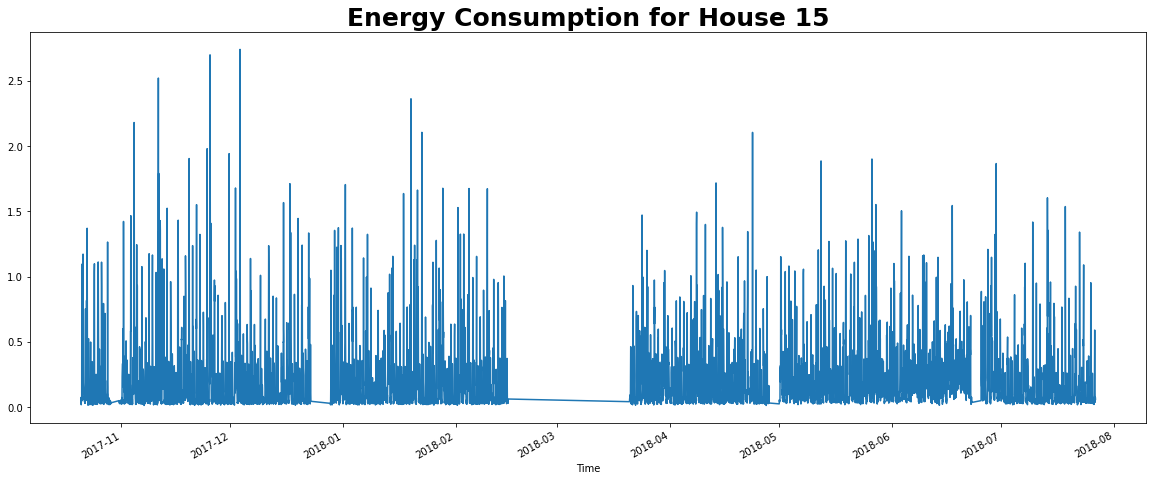

In [136]:
df_house15 = df_total_houses['House 15 Consumption']
df_house15.plot(figsize=(20,8))
plt.title('Energy Consumption for House 15', weight='bold', fontsize=25);

In [137]:
df_house15_train, df_house15_test = df_house15[df_house15.index < '2018-07-01'], df_house15[df_house15.index >= '2018-07-01']

print('Train:\t', len(df_house15_train))
print('Test:\t', len(df_house15_test))

Train:	 4965
Test:	 624


In [138]:
df_house15_train = df_house15_train.to_frame('House 15 Consumption')
df_house15_test = df_house15_test.to_frame('House 15 Consumption')

In [139]:
dataset = tf.expand_dims(df_house15_train.head(10), axis=-1)

# Generate a tf dataset with 10 elements (i.e. numbers 0 to 9)
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# Window the data but only take those with the specified size
dataset = dataset.window(5, shift=1, drop_remainder=True)

# Flatten the windows by putting its elements in a single batch
dataset = dataset.flat_map(lambda window: window.batch(5))

# Create tuples with features (first four elements of the window) and labels (last element)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# # Shuffle the windows
# dataset = dataset.shuffle(buffer_size=10)

# # Create batches of windows
# dataset = dataset.batch(2).prefetch(1)

# Print the results
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print()

x =  [[[0.03331128]]

 [[0.0737764 ]]

 [[0.01758619]]

 [[0.06992595]]]
y =  [[0.04405296]]

x =  [[[0.0737764 ]]

 [[0.01758619]]

 [[0.06992595]]

 [[0.04405296]]]
y =  [[0.06734338]]

x =  [[[0.01758619]]

 [[0.06992595]]

 [[0.04405296]]

 [[0.06734338]]]
y =  [[1.09419552]]

x =  [[[0.06992595]]

 [[0.04405296]]

 [[0.06734338]]

 [[1.09419552]]]
y =  [[0.52624082]]

x =  [[[0.04405296]]

 [[0.06734338]]

 [[1.09419552]]

 [[0.52624082]]]
y =  [[0.31170056]]

x =  [[[0.06734338]]

 [[1.09419552]]

 [[0.52624082]]

 [[0.31170056]]]
y =  [[0.06058935]]



In [140]:
train = windowing(df_house15_train['House 15 Consumption'], 24, 72, 32)
test = windowing(df_house15_test['House 15 Consumption'], 24, 72, 32)

In [141]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[24,1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1)
])

dnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 24, 16)            64        
                                                                 
 bidirectional_13 (Bidirecti  (None, 32)               4224      
 onal)                                                           
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,833
Trainable params: 4,833
Non-trainable params: 0
_________________________________________________________________


In [142]:
dnn_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
dnn_model.fit(train, validation_data=test, epochs=20)

Epoch 1/20
155/155 [==============================] - 5s 15ms/step - loss: 0.0708 - val_loss: 0.0464
Epoch 2/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0635 - val_loss: 0.0451
Epoch 3/20
155/155 [==============================] - 2s 13ms/step - loss: 0.0612 - val_loss: 0.0422
Epoch 4/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0598 - val_loss: 0.0408
Epoch 5/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0592 - val_loss: 0.0403
Epoch 6/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0585 - val_loss: 0.0412
Epoch 7/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0586 - val_loss: 0.0402
Epoch 8/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0580 - val_loss: 0.0401
Epoch 9/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0580 - val_loss: 0.0401
Epoch 10/20
155/155 [==============================] - 2s 14ms/step - loss: 0.0578 - val_lo

In [143]:
window_size = 24
forecast = []

train_length = len(df_house15_train)

forecast_series = df_house15[train_length - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
    forecast.append(dnn_model.predict(np.expand_dims(forecast_series[time:time + window_size], axis=-1)[np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()
df_house15_test['Pred'] = results

1/1 [==============================] - 0s 19ms/step


In [144]:
mse = round(mean_squared_error(df_house15_test['House 15 Consumption'], df_house15_test['Pred']), 3)
mse

0.039

In [145]:
df_house15_test.to_csv('house15_cons_pred.csv')